<a href="https://colab.research.google.com/github/DataCrusade1999/Qgraph/blob/main/Qgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import feyn

# Installing Feyn 

In [2]:
rentals = pd.read_csv('AB_NYC_2019.csv')
rentals.head(3)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.9724,Private room,149,1,9.0,2018-10-19,0.21,6,365.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.9838,Entire home/apt,225,1,45.0,2019-05-21,0.38,2,355.0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Private room,150,3,0.0,NaN,NaN,1,365.0


#Cleaning Data

In [3]:
rentals = rentals.drop(["id", "host_id","host_name", "name", "last_review"], axis=1)

In [4]:
from scipy import stats

#We drop all rows with NaN values
rentals = rentals.dropna() 

#Then we drop all prices that are equal to 0
rentals = rentals[rentals.price != 0]

#Finally we drop values that are further than three standard deviations from the mean.
z = np.abs(stats.zscore(rentals['price'])) 
rentals = rentals[z<3]

# Train Test Split

In [5]:
train, test = feyn.tools.split(rentals, ratio=(80,20))

# Initialising QLattice And Resetting Weights

In [6]:
ql = feyn.QLattice(url="https://qlattice.abzu.ai/qlattice-f7261e97", api_token="5be2fb0c8e054099bfa3530d13ac461b")
ql.reset()

#Categorical or Object Data

In [7]:
types = {}

for var in train.columns:
    if train[var].dtype == 'object':
        types[var] = 'categorical'
        
types

{'longitude': 'categorical',
 'neighbourhood': 'categorical',
 'neighbourhood_group': 'categorical',
 'room_type': 'categorical'}

#An Untrained Qgraph

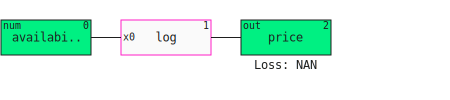

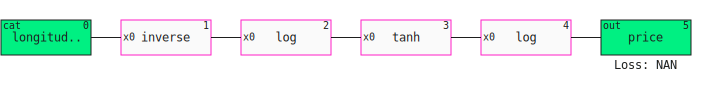

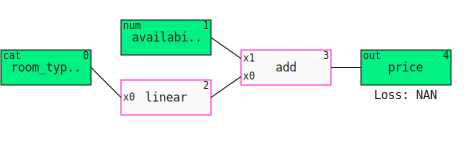

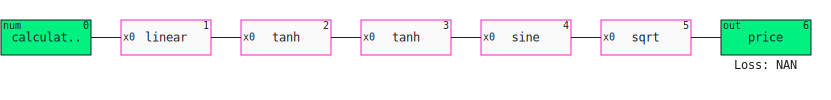

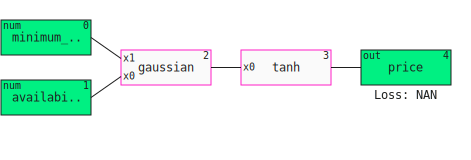

In [8]:
target = 'price'

qgraph = ql.get_regressor(registers=train.columns, output=target, max_depth=5, stypes=types)
qgraph.head()

#Training A Qgraph

In [9]:
qgraph.fit(train, loss_function=feyn.losses.squared_error, threads=4)

QGraph (depth<=5) <head: 1031>

#Picking The Best Qgraph

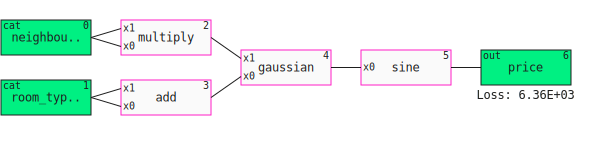

In [10]:
best = qgraph[0]
best

In [11]:
ql.update(best)

In [12]:
for _ in range(10):
    qgraph.fit(train, loss_function=feyn.losses.squared_error, threads=4)
    best = qgraph[0]
    ql.update(best)

#Predictions

In [13]:
pred_train = best.predict(train)
pred_test = best.predict(test)

#Plotting The Results

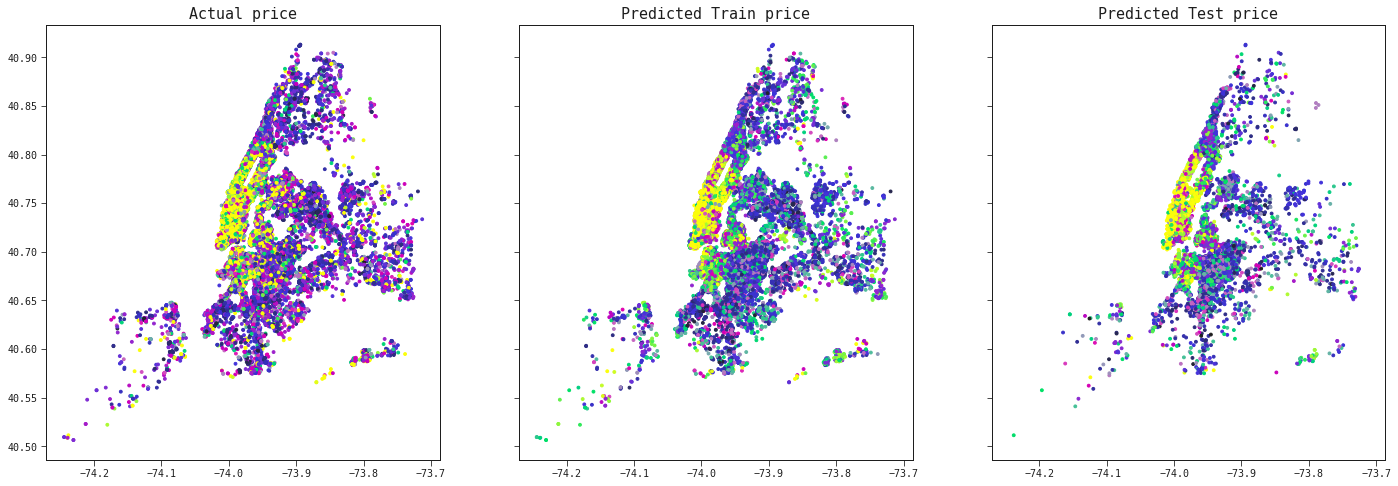

In [14]:
import matplotlib.pyplot as plt

f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(24,8))

ax1.scatter(rentals["longitude"],rentals["latitude"], c=rentals[target], vmax=200, s=8)
ax1.set_title('Actual price')
ax2.scatter(train["longitude"], train["latitude"], c=pred_train, vmax=200, s=8)
ax2.set_title('Predicted Train price')
ax3.scatter(test["longitude"], test["latitude"], c=pred_test, vmax=200, s=8)
ax3.set_title('Predicted Test price')
plt.show()